In [17]:
import pandas as pd
import matplotlib.pyplot as plt

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
import tensorflow as tf 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import os, shutil
import numpy as np


In [2]:
df = pd.read_csv("C:\\Users\\david\\OneDrive\\Inholland\\DeepLearning\\Assignment 1\\palmerpenguins_original.csv")


# 1 Preprocessing 
Firstly the data must be analysed and cleaned.
Thereafter, to decide what variables to use as predictors we must employ descriptive statistics to analyse what variables are relevant.
# 1.1 Data analysis


In [3]:
# Check for null values in each column and sum them up
null_counts = df.isnull().sum()

# Print the count of null values for each column
print("Null value counts for each column:")
print(null_counts)

# Find rows with null values
rows_with_null = df[df.isnull().any(axis=1)]

# Display rows with null values
print("Rows with null values:")
print(rows_with_null)

# Print the shape of the DataFrame
print("Shape of the DataFrame:")
print(df.shape)

Null value counts for each column:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64
Rows with null values:
    species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
3    Adelie  Torgersen             NaN            NaN                NaN   
8    Adelie  Torgersen            34.1           18.1              193.0   
9    Adelie  Torgersen            42.0           20.2              190.0   
10   Adelie  Torgersen            37.8           17.1              186.0   
11   Adelie  Torgersen            37.8           17.3              180.0   
47   Adelie      Dream            37.5           18.9              179.0   
178  Gentoo     Biscoe            44.5           14.3              216.0   
218  Gentoo     Biscoe            46.2           14.4              214.0   
256  Gentoo     Biscoe            47.3           13.8

# 1.2 Data Cleaning and encoding
Given the results of the null values the decision I decided was to drop the null rows which contain no body_mass as that is the target variable. Furthermore, I decided to add sex to the data based on the mode to compensate for the null values.
To do certain statistics on the categorical data the data must be encoded. With Pandas get_dummies uses "One-Hot encoding" to encode the categorical data.

In [4]:
df.dropna(subset=["body_mass_g"], inplace=True)
df["sex"].fillna(df["sex"].mode()[0], inplace=True)
print(df.isnull().sum())

encoded_values = pd.get_dummies(df, columns=["species", "island","sex","year"], drop_first=True)

print(encoded_values)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
year                 0
dtype: int64
     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
0              39.1           18.7              181.0       3750.0   
1              39.5           17.4              186.0       3800.0   
2              40.3           18.0              195.0       3250.0   
4              36.7           19.3              193.0       3450.0   
5              39.3           20.6              190.0       3650.0   
..              ...            ...                ...          ...   
339            55.8           19.8              207.0       4000.0   
340            43.5           18.1              202.0       3400.0   
341            49.6           18.2              193.0       3775.0   
342            50.8           19.0              210.0       4100.0   
343            50.2           18.

# 1.3 Data Statistics 

In [5]:
stats_bill_length = df['bill_length_mm'].describe()
stats_bill_depth = df['bill_depth_mm'].describe()
stats_flipper_length = df['flipper_length_mm'].describe()

#target variable 
stats_body_mass = df['body_mass_g'].describe()

print(stats_bill_length,2)
print(stats_bill_depth,2)
print(stats_flipper_length,2)

print(stats_body_mass,2)

species_count = df['species'].value_counts()
island_count = df['island'].value_counts()
sex_count = df['sex'].value_counts()
year_count = df['year'].value_counts()

print(species_count)
print(island_count)
print(sex_count)
print(year_count)

count    342.000000
mean      43.921930
std        5.459584
min       32.100000
25%       39.225000
50%       44.450000
75%       48.500000
max       59.600000
Name: bill_length_mm, dtype: float64 2
count    342.000000
mean      17.151170
std        1.974793
min       13.100000
25%       15.600000
50%       17.300000
75%       18.700000
max       21.500000
Name: bill_depth_mm, dtype: float64 2
count    342.000000
mean     200.915205
std       14.061714
min      172.000000
25%      190.000000
50%      197.000000
75%      213.000000
max      231.000000
Name: flipper_length_mm, dtype: float64 2
count     342.000000
mean     4201.754386
std       801.954536
min      2700.000000
25%      3550.000000
50%      4050.000000
75%      4750.000000
max      6300.000000
Name: body_mass_g, dtype: float64 2
Adelie       151
Gentoo       123
Chinstrap     68
Name: species, dtype: int64
Biscoe       167
Dream        124
Torgersen     51
Name: island, dtype: int64
male      177
female    165
Name: sex, d

In [6]:
# Calculate correlation coefficients between target variable and predictor variables
correlation_matrix = encoded_values.corr()

# Extract correlation coefficients for the target variable
target_correlation = correlation_matrix['body_mass_g']

# Print correlation coefficients
print("Correlation coefficients between target variable and predictor variables:")
print(target_correlation)

Correlation coefficients between target variable and predictor variables:
bill_length_mm       0.595110
bill_depth_mm       -0.471916
flipper_length_mm    0.871202
body_mass_g          1.000000
species_Chinstrap   -0.291561
species_Gentoo       0.818198
island_Dream        -0.460411
island_Torgersen    -0.258979
sex_male             0.409315
year_2008            0.057319
year_2009            0.007790
Name: body_mass_g, dtype: float64


Given these results it is concluded that flipper length,bill_length and the gentoo species, has a high positive correlation. Meanwhile, the bill_depth and dream island pinguins give a negative correlation. it is also important to note that the sex has a slight correlation to the weight. Because of this the predictor variable that will be selected is flipper length, bill length and species. 

# 1.4 Splitting Dataset

Here the data is split in validation and testing sets to evaluate the model performance during training and after training. The validation set is used to monitor the model's performance during training. The testing set is used to evaluate the final model's performance on unseen data. Furthermore, before splitting the data, Normalization techniques were applied to scale the features to a similar range, usually between 0 and 1 or with a mean of 0 and a standard deviation of 1. Species is not normalized because it already consists of binary values (0 and 1).

In [8]:
# Selecting predictor variables ('species', 'bill_length_mm', 'flipper_length_mm') and target variable ('body_mass_g')
X = df[['species', 'bill_length_mm', 'flipper_length_mm']]
y = df['body_mass_g']

# One-hot encode categorical variable 'species'
X_encoded = pd.get_dummies(X, columns=['species'], drop_first=True)

print("Predictor variables (X):")
print(X_encoded .head())
print(f"Gentoo type: {X_encoded['species_Gentoo'].dtype}\n"
      f"Chinstrap type: {X_encoded['species_Chinstrap'].dtype}\n"
      f"bill_length type: {X_encoded['bill_length_mm'].dtype}\n"
      f"flipper_legth: {X_encoded['flipper_length_mm'].dtype}")

print("\nTarget variable (y):")
print(y.head())

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the numerical columns of X_encoded
numerical_cols = X_encoded.columns.drop(['species_Gentoo', 'species_Chinstrap'])
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

scaler_y = StandardScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

inputs = np.array(X_encoded)
targets = np.array(y_normalized)

print(targets.shape)


# Print the normalized predictor variables
print("Normalized Predictor variables (X):")
print(inputs.shape)

print("Normalized target variables (y):")
print(targets.shape)


# Split the dataset into 60% training 20% validation and 20% testing
X_train, X_split, y_train, y_split = train_test_split(inputs, targets.reshape(342, 1), test_size=0.4, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_split,y_split,test_size=.5)

# Display the shapes of the training and testing sets
print("Training set - Predictor variables:", X_train.shape)
print("Training set - Target variable:", y_train.shape)
print("Testing set - Predictor variables:", X_test.shape)
print("Testing set - Target variable:", y_test.shape)
print("Validation set - Predictor variables:", X_val.shape)
print("Validation set - Target variable:", y_val.shape)

Predictor variables (X):
   bill_length_mm  flipper_length_mm  species_Chinstrap  species_Gentoo
0            39.1              181.0                  0               0
1            39.5              186.0                  0               0
2            40.3              195.0                  0               0
4            36.7              193.0                  0               0
5            39.3              190.0                  0               0
Gentoo type: uint8
Chinstrap type: uint8
bill_length type: float64
flipper_legth: float64

Target variable (y):
0    3750.0
1    3800.0
2    3250.0
4    3450.0
5    3650.0
Name: body_mass_g, dtype: float64
(342,)
Normalized Predictor variables (X):
(342, 4)
Normalized target variables (y):
(342,)
Training set - Predictor variables: (205, 4)
Training set - Target variable: (205, 1)
Testing set - Predictor variables: (69, 4)
Testing set - Target variable: (69, 1)
Validation set - Predictor variables: (68, 4)
Validation set - Target variabl

# 2 A custom neural network


# Activation Function

In [9]:
def relu(x):
    return np.maximum(0,x)

def dydxrelu(x):
    dx = np.where(x > 0, 1, 0)
    return dx

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dydxsig(x):
    return sigmoid(x) * (1-sigmoid(x))

def tanh(x):
    """
    Hyperbolic tangent activation function.
    
    Parameters:
    x (numpy.ndarray): Input values.
    
    Returns:
    numpy.ndarray: Hyperbolic tangent values.
    """
    return np.tanh(x)

def tanh_derivative(x):
    """
    Derivative of the hyperbolic tangent activation function.
    
    Parameters:
    x (numpy.ndarray): Input values.
    
    Returns:
    numpy.ndarray: Derivative values.
    """
    return 1 - np.tanh(x) ** 2

# Loss
y= true value                                                 
y_hat = predicted value

In [10]:
def mse(y, y_hat):
        return np.mean((y - y_hat) ** 2)

def mse_derivative(y, y_hat):
    return 2 * (y_hat - y)

def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

def mae_derivative(y, y_hat):
    diff = y_hat - y
    derivative = np.where(diff > 0, 1, -1)
    return derivative / y.shape[0]

# Network code

In [11]:
def initialize_weights(input_size, hidden_size, output_size):
    weights_input_hidden = np.random.randn(input_size, hidden_size)
    biases_input_hidden = np.zeros((1, hidden_size))
    weights_hidden_output = np.random.randn(hidden_size, output_size)
    biases_hidden_output = np.zeros((1, output_size))
    return weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output

def forward_pass(X, weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output):
    hidden_layer_input = np.dot(X, weights_input_hidden) + biases_input_hidden
    hidden_layer_output = relu(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + biases_hidden_output

    return output_layer_input, hidden_layer_input, hidden_layer_output

def backpropagation(X, output, output_delta, hidden_layer_input, hidden_layer_output, weights_hidden_output, biases_hidden_output, weights_input_hidden, biases_input_hidden, learning_rate):
    hidden_error = np.dot(output_delta, weights_hidden_output.T)
    hidden_delta = hidden_error * dydxrelu(hidden_layer_input)
    weights_hidden_output -= learning_rate * np.dot(hidden_layer_output.T, output_delta)
    biases_hidden_output -= learning_rate * np.sum(output_delta, axis=0, keepdims=True)
    weights_input_hidden -= learning_rate * np.dot(X.T, hidden_delta)
    biases_input_hidden -= learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)

def train_model(X_train, y_train, hidden_size=10, learning_rate=0.0001, epochs=1000):
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output = initialize_weights(input_size, hidden_size, output_size)
    
    for epoch in range(epochs):
        # Forward pass
        output_layer_input, hidden_layer_input, hidden_layer_output = forward_pass(X_train, weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output)

        # Compute loss
        loss = mse(y_train, output_layer_input)
    
        # Backpropagation
        output_error = mse_derivative(y_train, output_layer_input)
        backpropagation(X_train, output_layer_input, output_error, hidden_layer_input, hidden_layer_output, weights_hidden_output, biases_hidden_output, weights_input_hidden, biases_input_hidden, learning_rate)

        # Print progress
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")

    return weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output


# Train

In [92]:
# Example usage:
input_size = X_train.shape[1]
output_size = y_train.reshape(205, 1).shape[1]
learning_rate = 0.0001
epochs = 1000
hidden_size = 10

# Train the model
weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output = train_model(X_train, y_train.reshape(205,1), hidden_size, learning_rate, epochs)



Epoch 1/1000, Loss: 6.437537014896509
Epoch 2/1000, Loss: 2.1651463978248775
Epoch 3/1000, Loss: 1.1735003845234235
Epoch 4/1000, Loss: 0.8623889258632674
Epoch 5/1000, Loss: 0.7496191397387622
Epoch 6/1000, Loss: 0.6956346286431571
Epoch 7/1000, Loss: 0.6628781862277825
Epoch 8/1000, Loss: 0.6385489332009836
Epoch 9/1000, Loss: 0.6184270334985121
Epoch 10/1000, Loss: 0.6005091006507718
Epoch 11/1000, Loss: 0.5835216205327837
Epoch 12/1000, Loss: 0.5672559724401071
Epoch 13/1000, Loss: 0.5518558182694427
Epoch 14/1000, Loss: 0.5372832048511627
Epoch 15/1000, Loss: 0.5237601429689119
Epoch 16/1000, Loss: 0.5115931871104096
Epoch 17/1000, Loss: 0.5003131426286724
Epoch 18/1000, Loss: 0.48961215625927546
Epoch 19/1000, Loss: 0.47938012824136006
Epoch 20/1000, Loss: 0.4695154011126378
Epoch 21/1000, Loss: 0.46005942125052524
Epoch 22/1000, Loss: 0.45101163179571996
Epoch 23/1000, Loss: 0.4422839824997361
Epoch 24/1000, Loss: 0.4339838758562659
Epoch 25/1000, Loss: 0.4260333093345368
Epoch 

# Evaluate

In [93]:
# Perform forward pass on validation set
val_output, _, _ = forward_pass(X_val, weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output)

# Calculate validation loss
val_loss = mae(y_val, val_output)

val_normal_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1))
val_normal_predict = scaler_y.inverse_transform(val_output.reshape(-1, 1))

results_val = np.concatenate((val_normal_actual, val_normal_predict), axis=1)

results_val_df = pd.DataFrame(results_val, columns=['Actual Weight (g)', 'Predicted Weight (g)'])

print(results_val_df)
print(f"Validation Loss: {val_loss}")

    Actual Weight (g)  Predicted Weight (g)
0              4400.0           4019.945561
1              4000.0           4898.032389
2              3475.0           3863.600282
3              5250.0           5531.414732
4              3950.0           3581.327778
..                ...                   ...
63             2850.0           3355.603970
64             4450.0           4418.769764
65             5500.0           5305.028410
66             4500.0           4171.061472
67             4750.0           5271.581462

[68 rows x 2 columns]
Validation Loss: 0.3506552433700283


In [94]:
test_output, _, _ = forward_pass(X_test, weights_input_hidden, biases_input_hidden, weights_hidden_output, biases_hidden_output)

test_normal_actual =  scaler_y.inverse_transform(y_test.reshape(-1, 1))
test_normal_predict = scaler_y.inverse_transform(test_output.reshape(-1, 1))

# Calculate test loss
test_loss = mae(y_test, test_output)

results_test = np.concatenate((test_normal_actual, test_normal_predict), axis=1)

results_test_df = pd.DataFrame(results_test, columns=['Actual Weight (g)', 'Predicted Weight (g)'])

print(results_test_df)

print(f"Test Loss: {test_loss}")

    Actual Weight (g)  Predicted Weight (g)
0              4900.0           4846.753082
1              4750.0           4921.394717
2              5750.0           5437.226784
3              3700.0           3398.099281
4              4300.0           4095.032538
..                ...                   ...
64             4725.0           5173.757926
65             3800.0           3442.567188
66             4250.0           3740.523231
67             6000.0           5376.611916
68             3200.0           3535.693219

[69 rows x 2 columns]
Test Loss: 0.3676616040080052


# 3 Keras fully connected network

# Model 1

In [35]:
model_1 = Sequential()
model_1.add(Dense(16,input_shape = (X_train.shape[1],),activation= 'relu'))
model_1.add(Dense(1,activation='linear'))

In [58]:
##Compile the model 

model_1.compile(loss = tf.keras.losses.MeanSquaredError() ,
               optimizer= keras.optimizers.Adam(learning_rate=.001) , 
               metrics = ['mse'])

In [83]:
## fit the model 
callback = EarlyStopping(monitor = 'val_loss', patience = 25)
# Create a ModelCheckpoint callback
checkpoint_1 = ModelCheckpoint("best_model_1.h5", save_best_only=True, monitor='val_loss')

train_1 = model_1.fit(X_train,y_train, epochs =1000,verbose =1,validation_data=(X_val,y_val), batch_size= 32,callbacks=[callback,checkpoint_1])

Epoch 1/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.1520 - mse: 0.1520 - val_loss: 0.1776 - val_mse: 0.1776
Epoch 2/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.1521 - mse: 0.1521 - val_loss: 0.1776 - val_mse: 0.1776
Epoch 3/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.1522 - mse: 0.1522 - val_loss: 0.1780 - val_mse: 0.1780
Epoch 4/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.1521 - mse: 0.1521 - val_loss: 0.1781 - val_mse: 0.1781
Epoch 5/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.1523 - mse: 0.1523 - val_loss: 0.1781 - val_mse: 0.1781
Epoch 6/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.1522 - mse: 0.1522 - val_loss: 0.1777 - val_mse: 0.1777
Epoch 7/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1519 - mse: 0.1519 - val_loss: 0.1775 - val_mse: 0.1775
Epoch 8/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.1518 - m

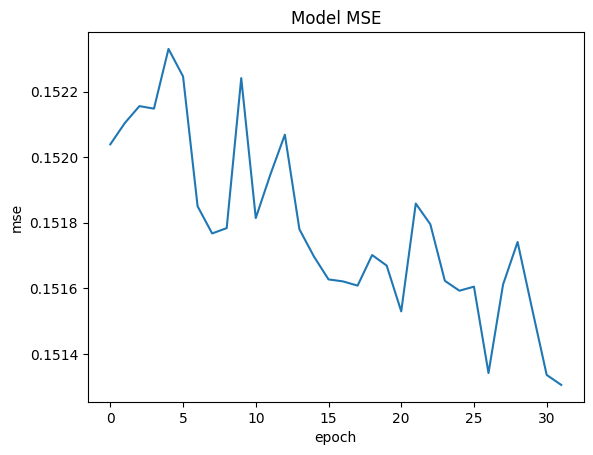

In [84]:

plt.plot(train_1.history['mse'])
plt.title("Model MSE")
plt.ylabel("mse")
plt.xlabel("epoch")
plt.show()

# Model 2

In [60]:
model_2 = Sequential()
model_2.add(Dense(64,input_shape = (X_train.shape[1],),activation= 'relu'))
model_2.add(Dense(32,activation='relu'))
model_2.add(Dense(1,activation='linear'))


In [61]:
##Compile the model 

model_2.compile(loss = tf.keras.losses.MeanSquaredError() ,
               optimizer= keras.optimizers.Adam(learning_rate=.001) , 
               metrics = ['mse'])

In [85]:
## fit the model 
callback = EarlyStopping(monitor = 'val_loss', patience = 25)
# Create a ModelCheckpoint callback
checkpoint_2 = ModelCheckpoint("best_model_2.h5", save_best_only=True, monitor='val_loss')

train_2 = model_2.fit(X_train,y_train, epochs =1000,verbose =1,validation_data=(X_val,y_val), batch_size= 32,callbacks=[callback,checkpoint_2])

Epoch 1/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.1563 - mse: 0.1563 - val_loss: 0.1888 - val_mse: 0.1888
Epoch 2/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.1585 - mse: 0.1585 - val_loss: 0.1903 - val_mse: 0.1903
Epoch 3/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.1535 - mse: 0.1535 - val_loss: 0.1914 - val_mse: 0.1914
Epoch 4/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.1556 - mse: 0.1556 - val_loss: 0.1888 - val_mse: 0.1888
Epoch 5/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.1544 - mse: 0.1544 - val_loss: 0.1915 - val_mse: 0.1915
Epoch 6/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.1551 - mse: 0.1551 - val_loss: 0.1887 - val_mse: 0.1887
Epoch 7/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.1540 - mse: 0.1540 - val_loss: 0.1893 - val_mse: 0.1893
Epoch 8/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.1534 - m

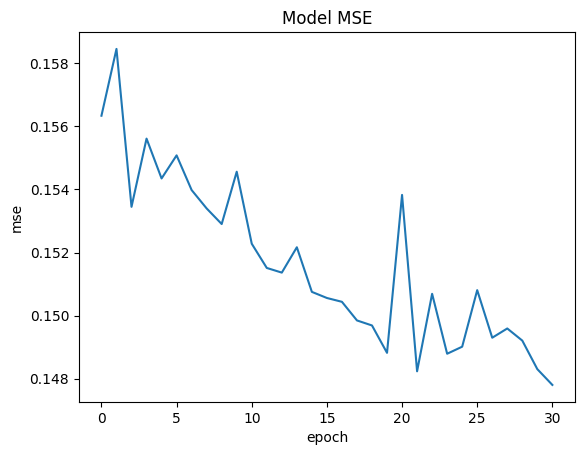

In [86]:
plt.plot(train_2.history['mse'])
plt.title("Model MSE")
plt.ylabel("mse")
plt.xlabel("epoch")
plt.show()

# Model 3

In [63]:
model_3 = Sequential()
model_3.add(Dense(128,input_shape = (X_train.shape[1],),activation= 'relu'))
model_3.add(Dense(64,activation='relu'))
model_3.add(Dense(32,activation = 'relu'))
model_3.add(Dense(1,activation='linear'))

In [64]:
##Compile the model 


model_3.compile(loss = tf.keras.losses.MeanSquaredError() ,
               optimizer= keras.optimizers.Adam(learning_rate=.001) , 
               metrics = ['mse'])

In [87]:
## fit the model 
callback = EarlyStopping(monitor = 'val_loss', patience = 25)
# Create a ModelCheckpoint callback
checkpoint_3 = ModelCheckpoint("best_model_3.h5", save_best_only=True, monitor='val_loss')

train_3 = model_3.fit(X_train,y_train, epochs =1000,verbose =1,validation_data=(X_val,y_val), batch_size= 32,callbacks=[callback,checkpoint_3])

Epoch 1/1000
7/7 [==============================] - 0s 40ms/step - loss: 0.1535 - mse: 0.1535 - val_loss: 0.1900 - val_mse: 0.1900
Epoch 2/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.1524 - mse: 0.1524 - val_loss: 0.1910 - val_mse: 0.1910
Epoch 3/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.1514 - mse: 0.1514 - val_loss: 0.1889 - val_mse: 0.1889
Epoch 4/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.1496 - mse: 0.1496 - val_loss: 0.1907 - val_mse: 0.1907
Epoch 5/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.1505 - mse: 0.1505 - val_loss: 0.1902 - val_mse: 0.1902
Epoch 6/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.1487 - mse: 0.1487 - val_loss: 0.1915 - val_mse: 0.1915
Epoch 7/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.1480 - mse: 0.1480 - val_loss: 0.1910 - val_mse: 0.1910
Epoch 8/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.1523 - m

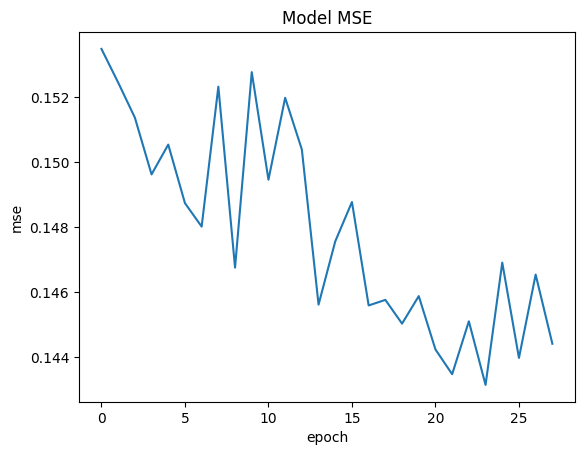

In [88]:
plt.plot(train_3.history['mse'])
plt.title("Model MSE")
plt.ylabel("mse")
plt.xlabel("epoch")
plt.show()

# Evaluation

In [89]:
##Load the best weights from training 
model_1.load_weights("best_model_1.h5")
model_2.load_weights("best_model_2.h5")
model_3.load_weights("best_model_3.h5")


In [90]:
##Model 1 predictions 
predictions_keras_1_standard= model_1.predict(X_test)
predictions_keras_1 = scaler_y.inverse_transform(predictions_keras_1_standard)
predictions_keras_1 = np.round(predictions_keras_1,3)

keras_model_mae_1 = mae(y_test,predictions_keras_1_standard)
print(f"Keras Sequential Model 1 MAE: {keras_model_mae_1}")


#Model 2 predictions
predictions_keras_2_standard = model_2.predict(X_test)
predictions_keras_2 = scaler_y.inverse_transform(predictions_keras_2_standard)
predictions_keras_2 = np.round(predictions_keras_2,3)

keras_model_mae_2 = mae(y_test,predictions_keras_2_standard)
print(f"Keras Sequential Model 2 MAE: {keras_model_mae_2}")

#3Model 3 Predictions 
predictions_keras_3_standard = model_3.predict(X_test)
predictions_keras_3 = scaler_y.inverse_transform(predictions_keras_3_standard)
predictions_keras_3 = np.round(predictions_keras_3,3)

keras_model_mae_3 = mae(y_test,predictions_keras_3_standard)
print(f"Keras Sequential Model 3 MAE: {keras_model_mae_3}")

3/3 [==============================] - 0s 3ms/step
Keras Sequential Model 1 MAE: 0.36129792164083135
3/3 [==============================] - 0s 5ms/step
Keras Sequential Model 2 MAE: 0.3564888530504986
3/3 [==============================] - 0s 4ms/step
Keras Sequential Model 3 MAE: 0.3550277679101403


# Comparison

In [95]:
results_keras1 = np.concatenate((test_normal_actual, predictions_keras_1), axis=1)
results_keras2 = np.concatenate((test_normal_actual, predictions_keras_2), axis=1)
results_keras3 = np.concatenate((test_normal_actual, predictions_keras_3), axis=1)

results_keras1_df = pd.DataFrame(results_keras1, columns=['Actual Weight (g)', 'Predicted Weight (g)'])
results_keras2_df = pd.DataFrame(results_keras2, columns=['Actual Weight (g)', 'Predicted Weight (g)'])
results_keras3_df = pd.DataFrame(results_keras3, columns=['Actual Weight (g)', 'Predicted Weight (g)'])

print(results_keras1_df)
print(results_keras2_df)
print(results_keras3_df)
print(results_test_df)

print(f"Keras1 Loss: {keras_model_mae_1}")
print(f"Keras2 Loss: {keras_model_mae_2}")
print(f"Keras3 Loss: {keras_model_mae_3}")
print(f"Handmade Loss: {test_loss}")


    Actual Weight (g)  Predicted Weight (g)
0              4900.0           4875.295898
1              4750.0           4913.636230
2              5750.0           5454.187988
3              3700.0           3387.978027
4              4300.0           4240.217773
..                ...                   ...
64             4725.0           5153.580078
65             3800.0           3448.552002
66             4250.0           3715.749023
67             6000.0           5402.470215
68             3200.0           3291.983887

[69 rows x 2 columns]
    Actual Weight (g)  Predicted Weight (g)
0              4900.0           4864.472168
1              4750.0           4905.757812
2              5750.0           5418.854980
3              3700.0           3379.462891
4              4300.0           4261.125977
..                ...                   ...
64             4725.0           5125.335938
65             3800.0           3430.865967
66             4250.0           3683.414062
67       